<center><h1></b>Data Engineer Job Analysis</b></h1></center>

1. Data Cleaning

2. Data visualization

**You can also check the same analysis on Data Scientist Jobs and Data Analyst Jobs**

1. [Data Analyst Job Analysis](https://www.kaggle.com/rohitsahoo/data-analyst-job-analysis)

2. [Data Scientist Job Analysis](https://www.kaggle.com/rohitsahoo/data-scientist-jobs-analysis) 


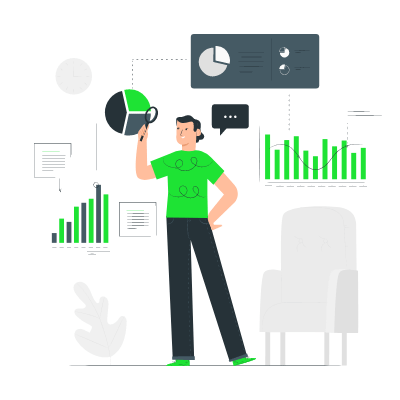

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

**Read the Data Engineer job dataset**

In [ ]:
df = pd.read_csv('../input/data-engineer-jobs/DataEngineer.csv')
df.shape

**This is how the dataset looks**

In [ ]:
df.head()

**For Better analysis, I have taken another dataset which consists of the latitudes and longitudes of the all the Stats in America!**

In [ ]:
states_df = pd.read_csv('../input/latitude-and-longitude-for-every-country-and-state/world_country_and_usa_states_latitude_and_longitude_values.csv')

# Data Cleaning

**There are some unnecessary columns,First drop these Columns**
1. Index
2. Unnamed
3. Easy Apply
4. Competitors

***Check whether any column has Null Values***

In [ ]:
print(df.isnull().any()) # To check whether any column in dataset has null values
df = df.drop(columns = ["Easy Apply","Competitors"]) # dropping the columns which I will not use for analysis
df.shape # Check the shape of the dataset -> Rows and Columns

**Let's split Salary Estimate into lower & upper bound**

And let's remove the rows having Salary on an hourly basis. We can change it and guess an estimate, but we don't know the no. of working hours

In [ ]:
df = df[~df["Salary Estimate"].str.contains("Per Hour")] # Removing the salary estimates given as per hour basis
df.shape # only 4 rows were deleted

**Clean up the Salary Estimate!**

In [ ]:
df["Salary Estimate"] = df["Salary Estimate"].replace("(Glassdoor est.)", "",regex=True) # Remove the "Glassdoor est." keyword
df["Salary Estimate"] = df["Salary Estimate"].replace("(Employer est.)", "",regex=True)  # Remove the "Employer est." Keyword
df["Salary Estimate"] = df["Salary Estimate"].replace("K", "",regex=True) # Remove the Letter K
df["Salary Estimate"] = df["Salary Estimate"].apply(lambda x: x.strip('()')) # Remove the "()" from the end
df["Salary Estimate"] = df["Salary Estimate"].replace("$", "",regex=True) # Remove the dollar '$' sign
df["Salary Estimate"] = df["Salary Estimate"].replace("-", " ",regex=True) # Remove the '-' sign

**Split Salary Estimate into lower & upper bound**

In [ ]:
df["Salary Estimate"] = df["Salary Estimate"].apply(lambda x: x.strip(' ')) # Remove the whitespaces
df[['Salary Estimate Lower Bound','Salary Estimate Upper Bound']] = df["Salary Estimate"].str.split(" ",expand=True) # split the Salary Estimate into upper and lower bound
df = df.drop(columns = "Salary Estimate") # drop the salary estimate column

In [ ]:
df["Salary Estimate Lower Bound"] = df["Salary Estimate Lower Bound"].replace({'\$':""},regex=True) # Remove the dollar '$' sign from lower bound
df["Salary Estimate Upper Bound"] = df["Salary Estimate Upper Bound"].replace({'\$':""},regex=True) # Remove the dollar '$' sign from upper bound

In [ ]:
df["Salary Estimate Lower Bound"] = df["Salary Estimate Lower Bound"].astype(str).astype(int) # Convert the column from string to integer
df["Salary Estimate Upper Bound"] = df["Salary Estimate Upper Bound"].astype(str).astype(int) # Convert the column from string to integer

**Similary, Let's split Size of a company into lower & upper bound!**

In [ ]:
df["Size"] = df["Size"].replace("employees", "",regex=True)  # Remove the "employees" keyword
df["Size"] = df["Size"].replace("to", " ",regex=True) # Remove the "to" keyword
df["Size"] = df["Size"].replace({'\+':" 0"},regex=True) # Remove the "+" sign


In [ ]:
df["Size"] = df["Size"].apply(lambda x: x.strip(' ')) # Remove the whitespaces
df["Size"] = df["Size"].replace("   ", " ",regex=True) # Replace double space with single space so that we can split the column
df[['Size Lower Bound','Size Upper Bound']] = df["Size"].str.split(" ",expand=True) # Split the Size column in upper and lower bound
df = df.drop(columns = "Size") # drop the Size column

**The 10000+ range was split with a lower bound of 10000 and upper bound as null**

**The lower bound is updated to 0 and the upper bound is updated to 10001.**

In [ ]:
df["Size Upper Bound"] = df["Size Upper Bound"].replace("0", "10001") 
df["Size Lower Bound"] = df["Size Lower Bound"].replace("10000", "0")

**Now let's remove the "\n & rating" from company Name**

In [ ]:
df['Company Name'] = df["Company Name"].str.partition("\n")

**Replace "-1" with "Unknown"**

In [ ]:
df["Size Lower Bound"] = df["Size Lower Bound"].replace("-1", "Unknown",regex=True)
df["Type of ownership"] = df["Type of ownership"].replace("-1", "Unknown",regex=True)
df["Industry"] = df["Industry"].replace("-1", "Unknown",regex=True)
df["Sector"] = df["Sector"].replace("-1", "Unknown",regex=True)

**Let's Make a new column of max revenue of a company**

**The filter_revenue function takes the input as the range of revenue and finds the max. revenue**

In [ ]:
def filter_revenue(x):
    revenue=0
    if(x== 'Unknown / Non-Applicable' or type(x)==float):
        revenue=0                                                                                   # Max Revenue will be 0 if the range is Unknown or non-applicable 
    elif(('million' in x) and ('billion' not in x)):
        maxRev = x.replace('(USD)','').replace("million",'').replace('$','').strip().split('to')    # Remove the words such as: USD, million, $, to
        if('Less than' in maxRev[0]):
            revenue = float(maxRev[0].replace('Less than','').strip())                              # Remove the "less than" keyword and also remove the whitespaces
        else:
            if(len(maxRev)==2):
                revenue = float(maxRev[1])
            elif(len(maxRev)<2): 
                revenue = float(maxRev[0])
    elif(('billion'in x)):
        maxRev = x.replace('(USD)','').replace("billion",'').replace('$','').strip().split('to')    # Remove the words such as: USD, billion, $, to
        if('+' in maxRev[0]):
            revenue = float(maxRev[0].replace('+','').strip())*1000                                 #  Remove the "+" sign and also remove the whitespaces
        else:
            if(len(maxRev)==2):
                revenue = float(maxRev[1])*1000
            elif(len(maxRev)<2):
                revenue = float(maxRev[0])*1000
    return revenue

In [ ]:
df['Max_revenue']=df['Revenue'].apply(lambda x: filter_revenue(x))

**We don't require the codes of all the countries, since our dataset mostly deals with states in America.**

In [ ]:
states_df = states_df.drop(columns = ["country_code","usa_state","country","latitude","longitude"])

In [ ]:
states_df = states_df.dropna() # drop the null values

**Split the Location into City and State**

In [ ]:
df[['City','State']] = df["Location"].str.split(",",expand=True) 
df = df[~df["State"].str.contains("United Kingdom")] # Removing United Kingdom from state!

In [ ]:
df['State'] = df['State'].str.lstrip() # Remove the whitespaces from front
latitude = states_df['usa_state_latitude'].to_list() # Make a list of all the states 
longitude = states_df['usa_state_longitude'].to_list() # Make a list of all the latitudes of a state
states = states_df['usa_state_code'].to_list() # Make a list of all the longitudes of a state

**To map the latitudes and longitudes to the states in the dataset we have to write a funtion!**

**Here the find_function finds the latitude of a given state. It takes the input as the Abbreviation of State (Given in Dataset), list of states and latitude.**

In [ ]:
def find_latitude(x,states,latitude):
    index = states.index(x)
    return latitude[index]

In [ ]:
def find_longitude(x,states,longitude):
    index = states.index(x)
    return longitude[index]

In [ ]:
df['latitude']= df['State'].apply(lambda x: find_latitude(x,states,latitude))
df['longitude']= df['State'].apply(lambda x: find_longitude(x,states,longitude))

**Let's check how the dataset looks after cleaning**

In [ ]:
df

# Data Visualization

In [ ]:
df1 = df[df["Rating"]>1]
sns.distplot(df1["Rating"],)
plt.title('Distribution of Ratings Column')
plt.show()

**Let's Look at the Cummulative Distributive Function for Ratings!**

In [ ]:
plt.hist(df1['Rating'], density=True, cumulative=True, label='CDF',histtype='step');

In [ ]:
sns.distplot(df["Salary Estimate Lower Bound"])
plt.title('Distribution of Salary Estimate Lower Bound Column')
plt.show()

In [ ]:
sns.distplot(df["Salary Estimate Upper Bound"])
plt.title('Distribution of Salary Estimate Lower Bound Column')
plt.show()

In [ ]:
plt.figure(figsize = (15,5))

df["Company Name"].value_counts().sort_values(ascending=False).head(20).plot.bar(color = "orange",fontsize=12, edgecolor='Red', linewidth = 2)
plt.title("Top 20 Company with Highest number of Jobs for Data Engineer Posistion")
plt.xlabel("Company Name",fontsize=15)
plt.ylabel("Count")

plt.show()

In [ ]:
plt.figure(figsize = (15,5))
df["Job Title"].value_counts().sort_values(ascending=False).head(20).plot.bar(color= "Red", fontsize=12, edgecolor='green',linewidth = 2)
plt.title("Top 20 Data Engineer Job")
plt.xlabel("Job Title",fontsize=15)
plt.ylabel("Count")
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
df["Location"].value_counts().sort_values(ascending=False).head(20).plot.bar(color= "Blue", fontsize=12)
plt.title("Top 20 locations for Data Engineer Job")
plt.xlabel("Locations",fontsize=15)
plt.ylabel("Count")
plt.show()

In [ ]:
plt.figure(figsize = (50,8))
df["Headquarters"].value_counts().sort_values(ascending=False).head(15).plot.pie(y="Headquarters",autopct="%0.1f%%")
plt.title("Head Quarters according to Locations")
plt.axis("off")
plt.show()

**So most of the Head Quarters are in New York, & "-1" is the no. of undeclared Head Quarters in the Dataset**

In [ ]:
plt.figure(figsize = (10,5))
df["Type of ownership"].value_counts().sort_values(ascending=False).plot.bar(color= "Orange",fontsize=12)
plt.title("Types of Ownership")
plt.xlabel("Ownership",fontsize=15)
plt.ylabel("Count")
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
df["Sector"].value_counts().sort_values(ascending=False).plot.bar(color= "red",fontsize=12)
plt.title("Different types of Sectors in Data Engineer job roles")
plt.xlabel("Sectors",fontsize=15)
plt.ylabel("Count")
plt.show()

In [ ]:
plt.figure(figsize = (10,5))
df["Founded"].value_counts().sort_values(ascending=False)[1:21].plot.bar(color= "Green",fontsize=12)
plt.title("Number of Company, Founded in a Year",fontsize=20)
plt.xlabel("Foundation Year",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

In [ ]:
ax = sns.boxplot(x=df["Rating"])

In [ ]:
df2 = df.groupby('Sector')[['Max_revenue']].mean().sort_values(['Max_revenue'],ascending=False).head(20)

In [ ]:
df2.head(20)

In [ ]:
df2.reset_index(inplace=True)
plt.figure(figsize=(10,5))
chart = sns.barplot(
    data=df2,
    x='Sector',
    y='Max_revenue'
)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=65, 
    horizontalalignment='right',
    fontweight='light',
 
)
chart.axes.yaxis.label.set_text("Revenue(Million dollars)")

In [ ]:
df3 = df.groupby('Industry')[['Max_revenue']].mean().sort_values(['Max_revenue'],ascending=False).head(20)

In [ ]:
df3.reset_index(inplace=True)
plt.figure(figsize=(10,5))
chart = sns.barplot(
    data=df3,
    x='Industry',
    y='Max_revenue',
    palette='Set1'
)
chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=65, 
    horizontalalignment='right',
    fontweight='light',
 
)
chart.axes.yaxis.label.set_text("Revenue(Million dollars)")


In [ ]:
from wordcloud import WordCloud
job_title=df['Job Title'][~pd.isnull(df['Job Title'])]
wordCloud = WordCloud(background_color = 'lightpink',width=2000,height= 2000).generate(' '.join(job_title))
plt.figure(figsize=(19,9))
plt.axis('off')
plt.title(df['Job Title'].name,fontsize=20)
plt.imshow(wordCloud)
plt.show()

**Let's do analysis on Job Description!**

**We will check how many jobs require skills such as Hadoop, Python, Machine Learning etc.?**

In [ ]:
pg_lan = ["python","c++","java","matlab",".net","c#","javascript","html","bash"]
big_data = ["big data","hadoop","spark","impala","cassandra","kafka","hdfs","hbase","hive"]
exp_edu = ["experience","bs","ms","phd","full-time","intern","remote","master","doctorate","computer science","bachelor"]
cloud = ["aws","gcp","azure","s3","redshift","ec2","lambda","route s3","dynamo db"]
ds_ml = ["machine learning","regression","stat","numpy","pandas","data visualization","data analysis","time series","data cleaning","deep learning"]
other_skills = ["sql","mongo db","excel","sas","nosql","communication"]
job = df["Job Description"].tolist()

In [ ]:
job = [x.lower() for x in job]

In [ ]:
pg_lan_required = defaultdict()
for item in pg_lan:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    pg_lan_required[item] = counter

pg_lan_df = pd.DataFrame(list(pg_lan_required.items()),columns = ['Programming Langauge','count']) 
pg_lan_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

In [ ]:
plt.figure(figsize = (15,5))
x = pg_lan_df["Programming Langauge"]
y = pg_lan_df["count"]
plt.bar(x,y,color= "blue")
plt.title("Top programming languages requrired by the companies",fontsize=15)
plt.xlabel("Programming Languages",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
for k,v in pg_lan_required.items():
    plt.text(k,v+25, str(v), fontsize=12, fontweight='bold',color='k', horizontalalignment='center');

In [ ]:
counter = 0
big_data_required = defaultdict()
for item in big_data:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    big_data_required[item] = counter

big_data_df = pd.DataFrame(list(big_data_required.items()),columns = ['Big Data Technologies','count']) 
big_data_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

In [ ]:
plt.figure(figsize = (15,5))
x = big_data_df["Big Data Technologies"]
y = big_data_df["count"]
plt.bar(x,y,color= "orange")
plt.title("Top Big Data Technologies requrired by the companies",fontsize=15)
plt.xlabel("Skills",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
for k,v in big_data_required.items():
    plt.text(k,v+5, str(v), fontsize=12, fontweight='bold',color='k', horizontalalignment='center');

In [ ]:
exp_edu_required = defaultdict()
for item in exp_edu:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    exp_edu_required[item] = counter
    
exp_edu_df = pd.DataFrame(list(exp_edu_required.items()),columns = ['Experience/Education','count']) 
exp_edu_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

In [ ]:
plt.figure(figsize = (15,5))
x = exp_edu_df["Experience/Education"]
y = exp_edu_df["count"]
plt.bar(x,y,color= "blue")
plt.title("Experience/Education requrired by the companies",fontsize=15)
plt.xlabel("Experience/Education",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
for k,v in exp_edu_required.items():
    plt.text(k,v+25, str(v), fontsize=12, fontweight='bold',color='k', horizontalalignment='center');

In [ ]:
counter = 0
cloud_required = defaultdict()
for item in cloud:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    cloud_required[item] = counter



cloud_df = pd.DataFrame(list(cloud_required.items()),columns = ['cloud ','count']) 
cloud_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

In [ ]:
plt.figure(figsize = (15,5))
x = cloud_df["cloud "]
y = cloud_df["count"]
plt.bar(x,y,color= "red")
plt.title("Top cloud computing skills requrired by the companies",fontsize=15)
plt.xlabel("Skills",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
for k,v in cloud_required.items():
    plt.text(k,v+5, str(v), fontsize=12, fontweight='bold',color='k', horizontalalignment='center');

In [ ]:
counter = 0
ds_ml_required = defaultdict()
for item in ds_ml:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    ds_ml_required[item] = counter

ds_ml_df = pd.DataFrame(list(ds_ml_required.items()),columns = ['Data Engineer /Machine Learning Skills ','count']) 
ds_ml_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

In [ ]:
plt.figure(figsize = (15,5))
x = ds_ml_df["Data Engineer /Machine Learning Skills "]
y = ds_ml_df["count"]
plt.bar(x,y,color= "orange")
plt.title("Top data Engineer  or machine learning skills requrired by the companies",fontsize=15)
plt.xlabel("Skills",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)

for k,v in ds_ml_required.items(): 
    plt.text(k,v+25, str(v), fontsize=12, fontweight='bold',color='k', horizontalalignment='center');

In [ ]:
counter = 0
other_skills_required = defaultdict()
for item in other_skills:
    counter = 0
    for it in job:
        if item in it:
            counter = counter + 1
    other_skills_required[item] = counter


other_skills_df = pd.DataFrame(list(other_skills_required.items()),columns = ['Other Skills ','count']) 
other_skills_df.sort_values(["count"], axis=0, ascending=False, inplace=True)

In [ ]:
plt.figure(figsize = (15,5))
plt.title("other top skills required by companies", fontsize=18)
plt.bar(other_skills_df["Other Skills "], other_skills_df["count"],color= "Green")
plt.xlabel("Skills",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)

for k,v in other_skills_required.items(): 
    plt.text(k,v+25, str(v), fontsize=12, fontweight='bold',color='k', horizontalalignment='center');

In [ ]:
import plotly.express as px
fig = px.scatter(df, x='Rating', y='Salary Estimate Upper Bound',color="Rating",hover_data=['Headquarters','Location', 'Type of ownership', 'Industry', 'Sector','Company Name'], title = "Data Engineer jobs")
fig.show()

In [ ]:
df_sal = df.groupby('Location')[['Salary Estimate Upper Bound','Salary Estimate Lower Bound']].mean().sort_values(['Salary Estimate Upper Bound','Salary Estimate Lower Bound'],ascending=False)[0:30]
df_sal.plot(kind="barh", figsize=(16,17), width=0.8)
plt.ylabel("Location")
plt.xlabel("Salary")
plt.title("Min and Max Salary From Different Location", fontweight="bold")

for index, value in enumerate(df_sal["Salary Estimate Upper Bound"]):
    plt.text(value + 0.5, index - 0.4, str(value))
    
    
for index, value in enumerate(df_sal["Salary Estimate Lower Bound"]):
    plt.text(value + 0.2, index + 0.1, str(value))

In [ ]:
df_sal = df.groupby('Job Title')[['Salary Estimate Upper Bound','Salary Estimate Lower Bound']].mean().sort_values(['Salary Estimate Upper Bound','Salary Estimate Lower Bound'],ascending=False)[:30]
df_sal.plot(kind="barh", figsize=(16,17), width=0.8)
plt.ylabel("Job Title")
plt.xlabel("Salary")
plt.title("Min and Max Salary of different Job Title", fontweight="bold")

for index, value in enumerate(df_sal["Salary Estimate Upper Bound"]):
    plt.text(value + 0.5, index - 0.4, str(value))
    
    
for index, value in enumerate(df_sal["Salary Estimate Lower Bound"]):
    plt.text(value + 0.2, index + 0.1, str(value))

In [ ]:
df["State"].value_counts().sort_values(ascending=False).head(20)

In [ ]:
import folium
import folium.plugins as plugins

In [ ]:
data_heat = df[['latitude','longitude','Rating']].values.tolist()

In [ ]:
import folium.plugins as plugins

m = folium.Map(location=[41, -102],zoom_start=4)

plugins.HeatMap(data_heat).add_to(m)

m